주문내역에 대한 학습용 데이터를 활용하여 주문건별 정시도착 여부(Reached.on.Time_Y.N)를 예측하는 모델을 개발한 후

이를 평가용 데이터에 적용하여 얻은 정시도착 여부 예측 확률을 csv 파일로 만들어 제출하시오

이때, csv 파일의 컬럼은 [테스트데이터의 ID, 정시도착 여부 예측확률] 로 구성하시오

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit, softmax
import statsmodels.api as sm

In [5]:
df = pd.read_csv("./data/E_commerce.csv")

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [143]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [144]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]
x

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,1,D,Flight,4,2,177,3,low,F,44,1233
1,2,F,Flight,4,5,216,2,low,M,59,3088
2,3,A,Flight,2,2,183,4,low,M,48,3374
3,4,B,Flight,3,3,176,4,medium,M,10,1177
4,5,C,Flight,2,2,184,3,medium,F,46,2484
...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247
10996,10997,C,Ship,5,4,242,5,low,F,4,1155
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210


In [13]:
def ohe_col(df: pd.DataFrame, col_name) -> pd.DataFrame:
    """
    범주형 텍스트 데이터를 숫자로 변환

    변환된 데이터list를 기존 DataFrame에 concat하는 함수
    """
    ohe = OneHotEncoder()
    ohe_arr = np.array(df[col_name])
    ohe_arr = np.reshape(ohe_arr, (-1, 1))

    ohe_name = ohe.fit_transform(ohe_arr)
    ohe_df = pd.DataFrame(ohe_name.toarray(), columns=ohe.get_feature_names_out())
    df = pd.concat([df, ohe_df], axis=1)

    return df

In [6]:
for col in list(df.select_dtypes(include="object").columns):
    df = ohe_col(df, col)

In [7]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,...,x0_D,x0_F,x0_Flight,x0_Road,x0_Ship,x0_high,x0_low,x0_medium,x0_F,x0_M
0,1,D,Flight,4,2,177,3,low,F,44,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2,F,Flight,4,5,216,2,low,M,59,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,A,Flight,2,2,183,4,low,M,48,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,B,Flight,3,3,176,4,medium,M,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,5,C,Flight,2,2,184,3,medium,F,46,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [244]:
x = df.drop("Reached.on.Time_Y.N", axis=1)
y = df["Reached.on.Time_Y.N"]
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    stratify=x[["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]],
)
x_train.shape, x_test.shape

((8249, 24), (2750, 24))

In [245]:
logi = LogisticRegression()
drop_col = [
    "Warehouse_block",
    "Mode_of_Shipment",
    "Product_importance",
    "Gender",
]
x_train = x_train.drop(drop_col, axis=1)
x_test = x_test.drop(drop_col, axis=1)

In [246]:
scale_col = x_train.columns[1:7].tolist()

In [247]:
x_train

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,x0_A,x0_B,x0_C,x0_D,x0_F,x0_Flight,x0_Road,x0_Ship,x0_high,x0_low,x0_medium,x0_F,x0_M
2217,2218,5,2,160,4,43,1479,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5268,5269,7,2,296,4,6,1005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7832,7833,5,4,265,2,2,5164,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9131,9132,6,3,256,4,9,1212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5361,5362,4,2,251,2,10,4898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,1197,4,2,187,4,49,3225,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6316,6317,7,3,310,4,8,1497,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8869,8870,4,4,261,5,2,1829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2989,2990,5,1,206,4,62,1137,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [248]:
logi.fit(x_train.drop("id", axis=1), y_train)
print(logi.score(x_train.drop("id", axis=1), y_train))
print(logi.score(x_test.drop("id", axis=1), y_test))

KeyError: "['id'] not found in axis"

- 스케일링 안한 값 모델링

In [249]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train.iloc[:, 1:7])
scaled_test = ss.transform(x_test.iloc[:, 1:7])

In [250]:
x_train.iloc[:, 1:7]

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
2217,5,2,160,4,43,1479
5268,7,2,296,4,6,1005
7832,5,4,265,2,2,5164
9131,6,3,256,4,9,1212
5361,4,2,251,2,10,4898
...,...,...,...,...,...,...
1196,4,2,187,4,49,3225
6316,7,3,310,4,8,1497
8869,4,4,261,5,2,1829
2989,5,1,206,4,62,1137


In [251]:
scaled_train

array([[ 0.83956193, -0.69642031, -1.03902992,  0.2958308 ,  1.84206289,
        -1.32199465],
       [ 2.59441974, -0.69642031,  1.78478998,  0.2958308 , -0.45235368,
        -1.61260513],
       [ 0.83956193,  0.72221684,  1.14112515, -1.02575504, -0.70039871,
         0.93728727],
       ...,
       [-0.03786698,  0.72221684,  1.05807162,  0.95662371, -0.70039871,
        -1.10740885],
       [ 0.83956193, -1.40573889, -0.08391437,  0.2958308 ,  3.0202768 ,
        -1.53167563],
       [-0.03786698,  0.72221684, -1.26742712, -1.02575504,  0.35379269,
        -1.20795762]])

In [252]:
scaled_train = pd.DataFrame(scaled_train, columns=scale_col)
scaled_test = pd.DataFrame(scaled_test, columns=scale_col)

In [253]:
scaled_train

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
0,0.839562,-0.696420,-1.039030,0.295831,1.842063,-1.321995
1,2.594420,-0.696420,1.784790,0.295831,-0.452354,-1.612605
2,0.839562,0.722217,1.141125,-1.025755,-0.700399,0.937287
3,1.716991,0.012898,0.954255,0.295831,-0.266320,-1.485693
4,-0.037867,-0.696420,0.850438,-1.025755,-0.204309,0.774202
...,...,...,...,...,...,...
8244,-0.037867,-0.696420,-0.478419,0.295831,2.214130,-0.251518
8245,2.594420,0.012898,2.075477,0.295831,-0.328331,-1.310959
8246,-0.037867,0.722217,1.058072,0.956624,-0.700399,-1.107409
8247,0.839562,-1.405739,-0.083914,0.295831,3.020277,-1.531676


In [254]:
scaled_train = pd.concat(
    [scaled_train, x_train.iloc[:, 7:-2].reset_index(drop=True)], axis=1
)


scaled_test = pd.concat(
    [scaled_test, x_test.iloc[:, 7:-2].reset_index(drop=True)], axis=1
)


# x_train
scaled_train

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,x0_A,x0_B,x0_C,x0_D,x0_F,x0_Flight,x0_Road,x0_Ship,x0_high,x0_low,x0_medium
0,0.839562,-0.696420,-1.039030,0.295831,1.842063,-1.321995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.594420,-0.696420,1.784790,0.295831,-0.452354,-1.612605,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.839562,0.722217,1.141125,-1.025755,-0.700399,0.937287,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.716991,0.012898,0.954255,0.295831,-0.266320,-1.485693,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.037867,-0.696420,0.850438,-1.025755,-0.204309,0.774202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8244,-0.037867,-0.696420,-0.478419,0.295831,2.214130,-0.251518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8245,2.594420,0.012898,2.075477,0.295831,-0.328331,-1.310959,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8246,-0.037867,0.722217,1.058072,0.956624,-0.700399,-1.107409,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8247,0.839562,-1.405739,-0.083914,0.295831,3.020277,-1.531676,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [263]:
# scaled_train = scaled_train.drop("Customer_rating",axis=1)
# scaled_test = scaled_test.drop("Customer_rating",axis=1)
# scaled_train = scaled_train.drop("Prior_purchases",axis=1)
# scaled_test = scaled_test.drop("Prior_purchases",axis=1)
logi.fit(scaled_train, y_train)
print(logi.score(scaled_train, y_train))
print(logi.score(scaled_test, y_test))

0.6346223784701176
0.6527272727272727


In [257]:
scaled_train

,Customer_care_calls,Cost_of_the_Product,Discount_offered,Weight_in_gms,x0_A,x0_B,x0_C,x0_D,x0_F,x0_Flight,x0_Road,x0_Ship,x0_high,x0_low,x0_medium
0,0.839562,-1.039030,1.842063,-1.321995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.594420,1.784790,-0.452354,-1.612605,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.839562,1.141125,-0.700399,0.937287,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.716991,0.954255,-0.266320,-1.485693,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.037867,0.850438,-0.204309,0.774202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8244,-0.037867,-0.478419,2.214130,-0.251518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8245,2.594420,2.075477,-0.328331,-1.310959,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8246,-0.037867,1.058072,-0.700399,-1.107409,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8247,0.839562,-0.083914,3.020277,-1.531676,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


<Axes: >

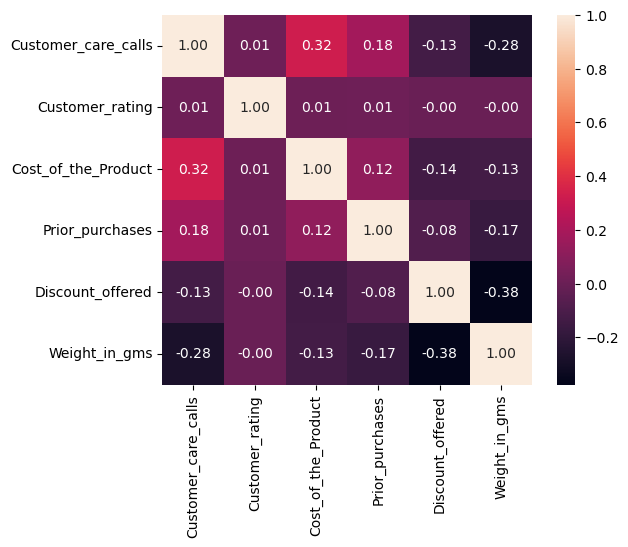

In [264]:
# corr_mat = np.corrcoef(df_corr.values.T)
plt.figure()
data = df.drop(drop_col, axis=1)
# sns.heatmap(data.iloc[:,:7].drop("Weight_in_gms",axis=1).corr())

sns.heatmap(
    data.iloc[:, 1:7].corr(),
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
)
# data[:]

In [265]:
x = sm.add_constant(scaled_train)
sm.OLS(y_train.reset_index(drop=True), x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Reached.on.Time_Y.N   R-squared:                       0.177
Model:                             OLS   Adj. R-squared:                  0.176
Method:                  Least Squares   F-statistic:                     148.0
Date:                 Thu, 28 Mar 2024   Prob (F-statistic):               0.00
Time:                         15:44:47   Log-Likelihood:                -5024.2
No. Observations:                 8249   AIC:                         1.007e+04
Df Residuals:                     8236   BIC:                         1.017e+04
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3295      0.004     81.272      0.000       0.322       0.337
Customer_care_calls    -0.0313      0.005     -5.699      0.000      -0.042      -0.021
Cost_of_the_Product    -0.0106      0.005     -2.019      0.043      -0.021      -0.000
Discount_offered        0.1552      0.006     28.011      0.000       0.144       0.166
Weight_in_gms          -0.0843      0.006    -14.761      0.000      -0.096      -0.073
x0_A                    0.0618      0.011      5.789      0.000       0.041       0.083
x0_B                    0.0776      0.011      7.274      0.000       0.057       0.099
x0_C                    0.0649      0.011      6.085      0.000       0.044       0.086
x0_D                    0.0621      0.011      5.831      0.000       0.041       0.083
x0_F                    0.0631      0.008      7.668      0.000       0.047       0.079
x0_Flight               0.1147      0.010     11.897      0.000       0.096       0.134
x0_Road                 0.1083      0.010     11.195      0.000       0.089       0.127
x0_Ship                 0.1064      0.006     16.443      0.000       0.094       0.119
x0_high                 0.1531      0.012     12.260      0.000       0.129       0.178
x0_low                  0.0891      0.007     12.288      0.000       0.075       0.103
x0_medium               0.0872      0.007     11.807      0.000       0.073       0.102
==============================================================================
Omnibus:                    37482.939   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              953.132
Skew:                          -0.025   Prob(JB):                    1.07e-207
Kurtosis:                       1.336   Cond. No.                     1.66e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.55e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [268]:
new = pd.DataFrame()

In [273]:
new["id"] = list(x_test["ID"])

In [279]:
decision_z = logi.decision_function(scaled_test)
np.round(decision_z, decimals=2)

array([-0.3 ,  4.95,  5.06, ...,  0.21, -0.25,  0.14])

In [289]:
proba = logi.predict_proba(scaled_test)
proba

array([[0.5739082 , 0.4260918 ],
       [0.00702438, 0.99297562],
       [0.00630643, 0.99369357],
       ...,
       [0.44668056, 0.55331944],
       [0.56286726, 0.43713274],
       [0.46569792, 0.53430208]])

In [291]:
arr = []
for i in proba:
    arr.append(max(i))

In [292]:
new["proba"] = arr

In [293]:
new

,id,proba
0,4337,0.573908
1,264,0.992976
2,2955,0.993694
3,1109,0.998288
4,6353,0.626361
...,...,...
2745,5593,0.504351
2746,761,0.654782
2747,10978,0.553319
2748,9403,0.562867


In [294]:
new.to_csv("Reached.on.Time_Y.N_proba.csv")